**Downloading Kaggle data sets directly into Colab**

Install the kaggle python library

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mount the Google drive so you can store your kaggle API credentials for future use

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
#! cp kaggle.json ~/.kaggle/

Upload the json file to Google Drive and then copy to the temporary location.

In [6]:
!cp /content/drive/MyDrive/bigdata/kaggle.json ~/.kaggle/kaggle.json

Change the file permissions to read/write to the owner only

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

**Competitions and Datasets are the two types of Kaggle data**

In [8]:
! kaggle datasets download odins0n/amex-parquet -f train_data.parquet


100% 2.85G/2.85G [00:21<00:00, 118MB/s]
100% 2.85G/2.85G [00:21<00:00, 142MB/s]


In [9]:
! unzip train_data.parquet

Archive:  train_data.parquet.zip
  inflating: train_data.parquet      


In [1]:

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
import warnings, gc
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [2]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [3]:
train=pd.read_parquet('train_data.parquet')

In [4]:
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))

titles=['Delinquency_'+str(i).split('_')[1] if i.startswith('D') else 'Spend_'+str(i).split('_')[1] 
        if i.startswith('S') else 'Payment_'+str(i).split('_')[1]  if i.startswith('P') 
        else 'Balance_'+str(i).split('_')[1] if i.startswith('B') else 
        'Risk_'+str(i).split('_')[1] for i in train.columns[:-1]]
cat_features=['Balance_30', 'Balance_38', 'Delinquency_63', 'Delinquency_64', 'Delinquency_66', 'Delinquency_68',
          'Delinquency_114', 'Delinquency_116', 'Delinquency_117', 'Delinquency_120', 'Delinquency_126']
titles.append('Target')
train.columns=titles
train.head()

,Risk_ID,Spend_2,Payment_2,Delinquency_39,Balance_1,Balance_2,Risk_1,Spend_3,Delinquency_41,Balance_3,...,Delinquency_137,Delinquency_138,Delinquency_139,Delinquency_140,Delinquency_141,Delinquency_142,Delinquency_143,Delinquency_144,Delinquency_145,Target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0


In [5]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of values in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 5531451
Number of columns in train data: 191
Number of values in train data: 895648173
Number missing values in train data: 160858968


In [6]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False))


Delinquency_87     5527586
Delinquency_88     5525447
Delinquency_108    5502513
Delinquency_110    5500117
Delinquency_111    5500117
                    ...   
Balance_24               0
Delinquency_75           0
Payment_4                0
Balance_23               0
Target                   0
Length: 191, dtype: int64


In [7]:
configure_plotly_browser_state()
FEATURES = list(train.columns[2:190])
TARGET = "target"
cont_features = [col for col in FEATURES if col not in cat_features]
labels=['Categorical', 'Continuous']
values= [len(cat_features), len(cont_features)]
colors = ['#DE3163', '#58D68D']

print(f'\033[94mTotal number of features: {len(FEATURES) + 2   }')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)-2}')

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, pull=[0.1, 0 ],
    marker=dict(colors=colors, 
                line=dict(color='#000000', 
                          width=2))
)])
fig.show()
print(FEATURES)

Total number of features: 190
Number of categorical features: 11
Number of continuos features: 175


['Payment_2', 'Delinquency_39', 'Balance_1', 'Balance_2', 'Risk_1', 'Spend_3', 'Delinquency_41', 'Balance_3', 'Delinquency_42', 'Delinquency_43', 'Delinquency_44', 'Balance_4', 'Delinquency_45', 'Balance_5', 'Risk_2', 'Delinquency_46', 'Delinquency_47', 'Delinquency_48', 'Delinquency_49', 'Balance_6', 'Balance_7', 'Balance_8', 'Delinquency_50', 'Delinquency_51', 'Balance_9', 'Risk_3', 'Delinquency_52', 'Payment_3', 'Balance_10', 'Delinquency_53', 'Spend_5', 'Balance_11', 'Spend_6', 'Delinquency_54', 'Risk_4', 'Spend_7', 'Balance_12', 'Spend_8', 'Delinquency_55', 'Delinquency_56', 'Balance_13', 'Risk_5', 'Delinquency_58', 'Spend_9', 'Balance_14', 'Delinquency_59', 'Delinquency_60', 'Delinquency_61', 'Balance_15', 'Spend_11', 'Delinquency_62', 'Delinquency_63', 'Delinquency_64', 'Delinquency_65', 'Balance_16', 'Balance_17', 'Balance_18', 'Balance_19', 'Delinquency_66', 'Balance_20', 'Delinquency_68', 'Spend_12', 'Risk_6', 'Spend_13', 'Balance_21', 'Delinquency_69', 'Balance_22', 'Delinqu

In [8]:
configure_plotly_browser_state()
target_df = pd.DataFrame(train['Target'].value_counts()).reset_index()
target_df.columns = ['Target', 'count']
fig = px.bar(data_frame =target_df, x = 'Target',y = 'count') 
fig.update_traces(marker_color =['#58D68D','#DE3163'], 
                  marker_line_color='rgb(0,0,0)',
                  marker_line_width=2,)
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Target = 0: {:.2f} %".format(target_df["count"][0]*100 / (target_df["count"][0]+ target_df["count"][1])))
print("\033[94mPercentage of Target = 1: {:.2f} %".format(target_df["count"][1]* 100 / (target_df["count"][0]+ target_df["count"][1])))
fig.show()

Percentage of Target = 0: 75.09 %
Percentage of Target = 1: 24.91 %


In [9]:
RANDOM_SPLIT = 100000
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']

**<h1> Default Percentage by day**

In [10]:
configure_plotly_browser_state()
target=pd.DataFrame(data={'Default':train.groupby('Spend_2')['Target'].mean()*100})
target['Paid']=np.abs(train.groupby('Spend_2')['Target'].mean()-1)*100
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig=go.Figure()
fig.add_trace(go.Bar(x=target.index, y=target.Paid, name='Paid',
                     text=target.Paid, texttemplate='%{text:.0f}%', 
                     textposition='inside',insidetextanchor="middle",
                     marker=dict(color=color[0],line=dict(color=pal[0],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Paid accounts: %{y:.2f}%"))
fig.add_trace(go.Bar(x=target.index, y=target.Default, name='Default',
                     text=target.Default, texttemplate='%{text:.0f}%', 
                     textposition='inside',insidetextanchor="middle",
                     marker=dict(color=color[1],line=dict(color=pal[1],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Default accounts: %{y:.2f}%"))
fig.update_layout(template=temp,title='Distribution of Default by Day', 
                  barmode='relative', yaxis_ticksuffix='%', width=1400,
                  legend=dict(orientation="h", traceorder="reversed", yanchor="bottom",y=1.1,xanchor="left", x=0))
fig.show()

<h1> About 25% of customers in the training data have defaulted. This proportion is consistent across each day in the training set.

**<h1> Categorical Features Distribution**

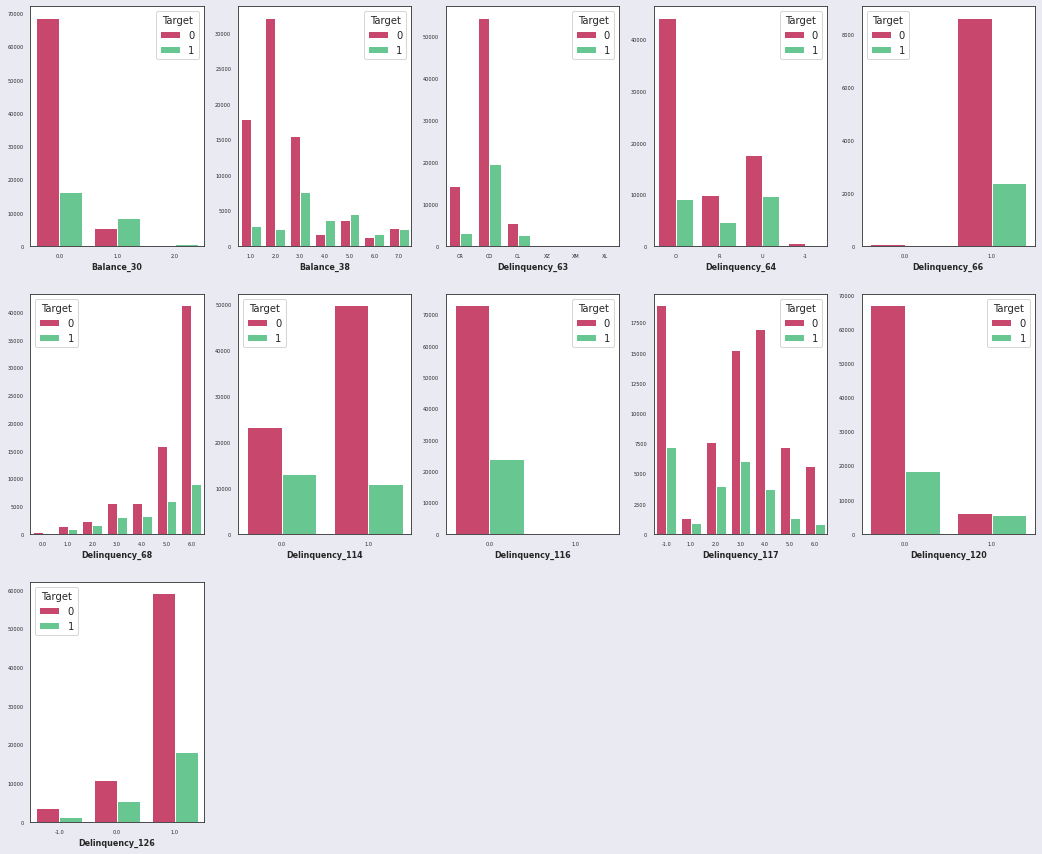

In [11]:
configure_plotly_browser_state()
sns.set_style(style='white')
ncols = 5
nrows = int(len(cat_features) / ncols + (len(FEATURES) % ncols > 0)) 

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 15), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        if r*ncols+c >= len(cat_features):
            break
        col = cat_features[r*ncols+c]
        sns.countplot(data=train.iloc[:RANDOM_SPLIT] , x = col, ax=axes[r, c], hue = "Target", palette =['#DE3163','#58D68D'])
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8, fontweight='bold')
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
fig.delaxes(axes[2][1])     
fig.delaxes(axes[2][2]) 
fig.delaxes(axes[2][3]) 
fig.delaxes(axes[2][4]) 
plt.show()

**<h1> Continuous Features Distribution**

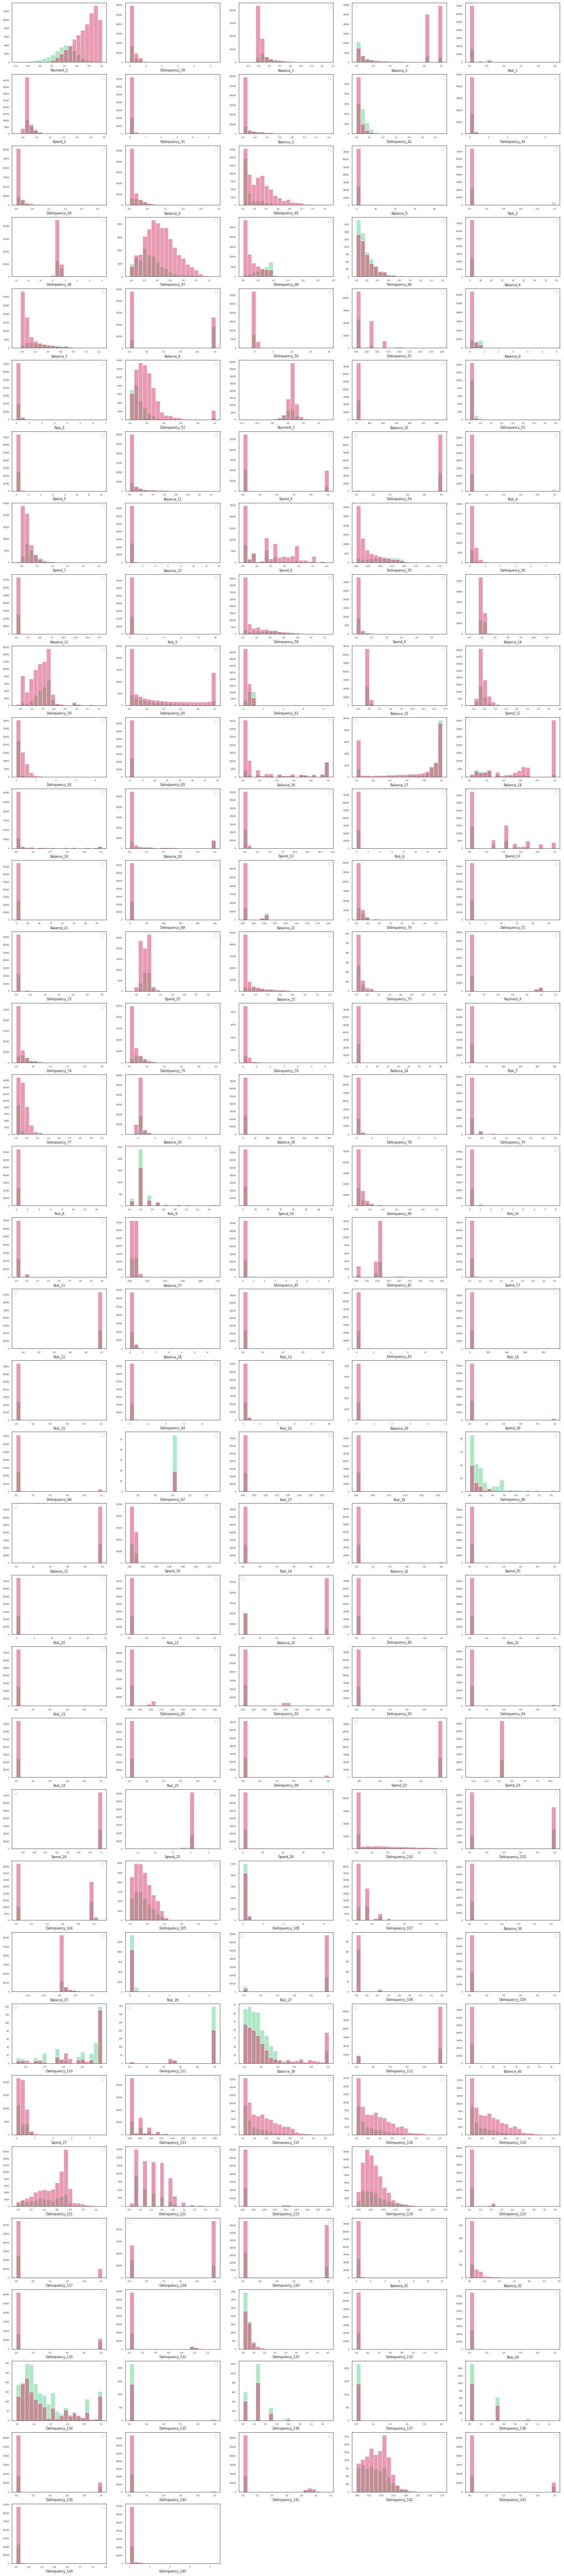

In [12]:
ncols = 5
nrows = 36
n_features = cont_features
fig, axes = plt.subplots(nrows, ncols, figsize=(25, 15*8))

for r in range(nrows):
    for c in range(ncols):
        if r*ncols+c == len(cont_features):
            break
        col = n_features[r*ncols+c]
        sns.histplot(data= train.iloc[:RANDOM_SPLIT],  x=col, ax=axes[r, c], hue= "Target", bins = 20, palette =['#DE3163','#58D68D'])
        axes[r,c].legend()
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8)
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(6)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
fig.delaxes(axes[35][2])
fig.delaxes(axes[35][3])   
fig.delaxes(axes[35][4])
plt.show()

**<h1> Correlation between Spend variables**

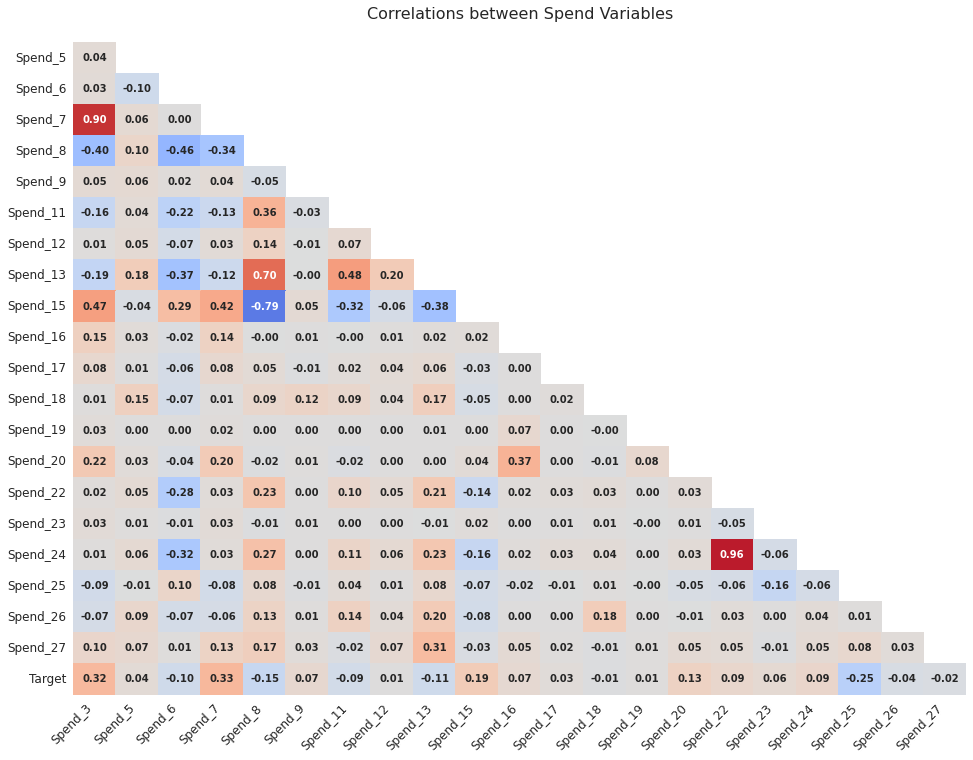

In [13]:
cols=[col for col in train.columns if (col.startswith(('S','T'))) & (col not in cat_features)]
plot_df=train[cols]
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(16,12))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Spend Variables\n', fontsize=16)
fig.show()

**<h1> Correlation between Payment variables**

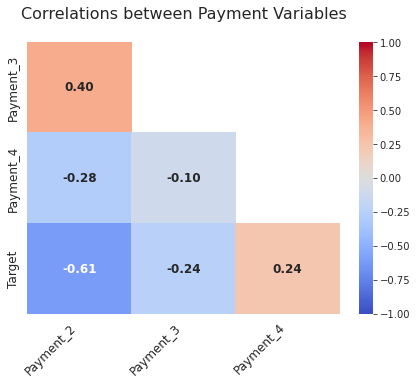

In [15]:
cols=[col for col in train.columns if (col.startswith(('P','T'))) & (col not in cat_features)]
plot_df=train[cols]
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(7,5)) 
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'})
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Payment Variables\n', fontsize=16)
fig.show()

**<h1> Correlation between Balance variables**

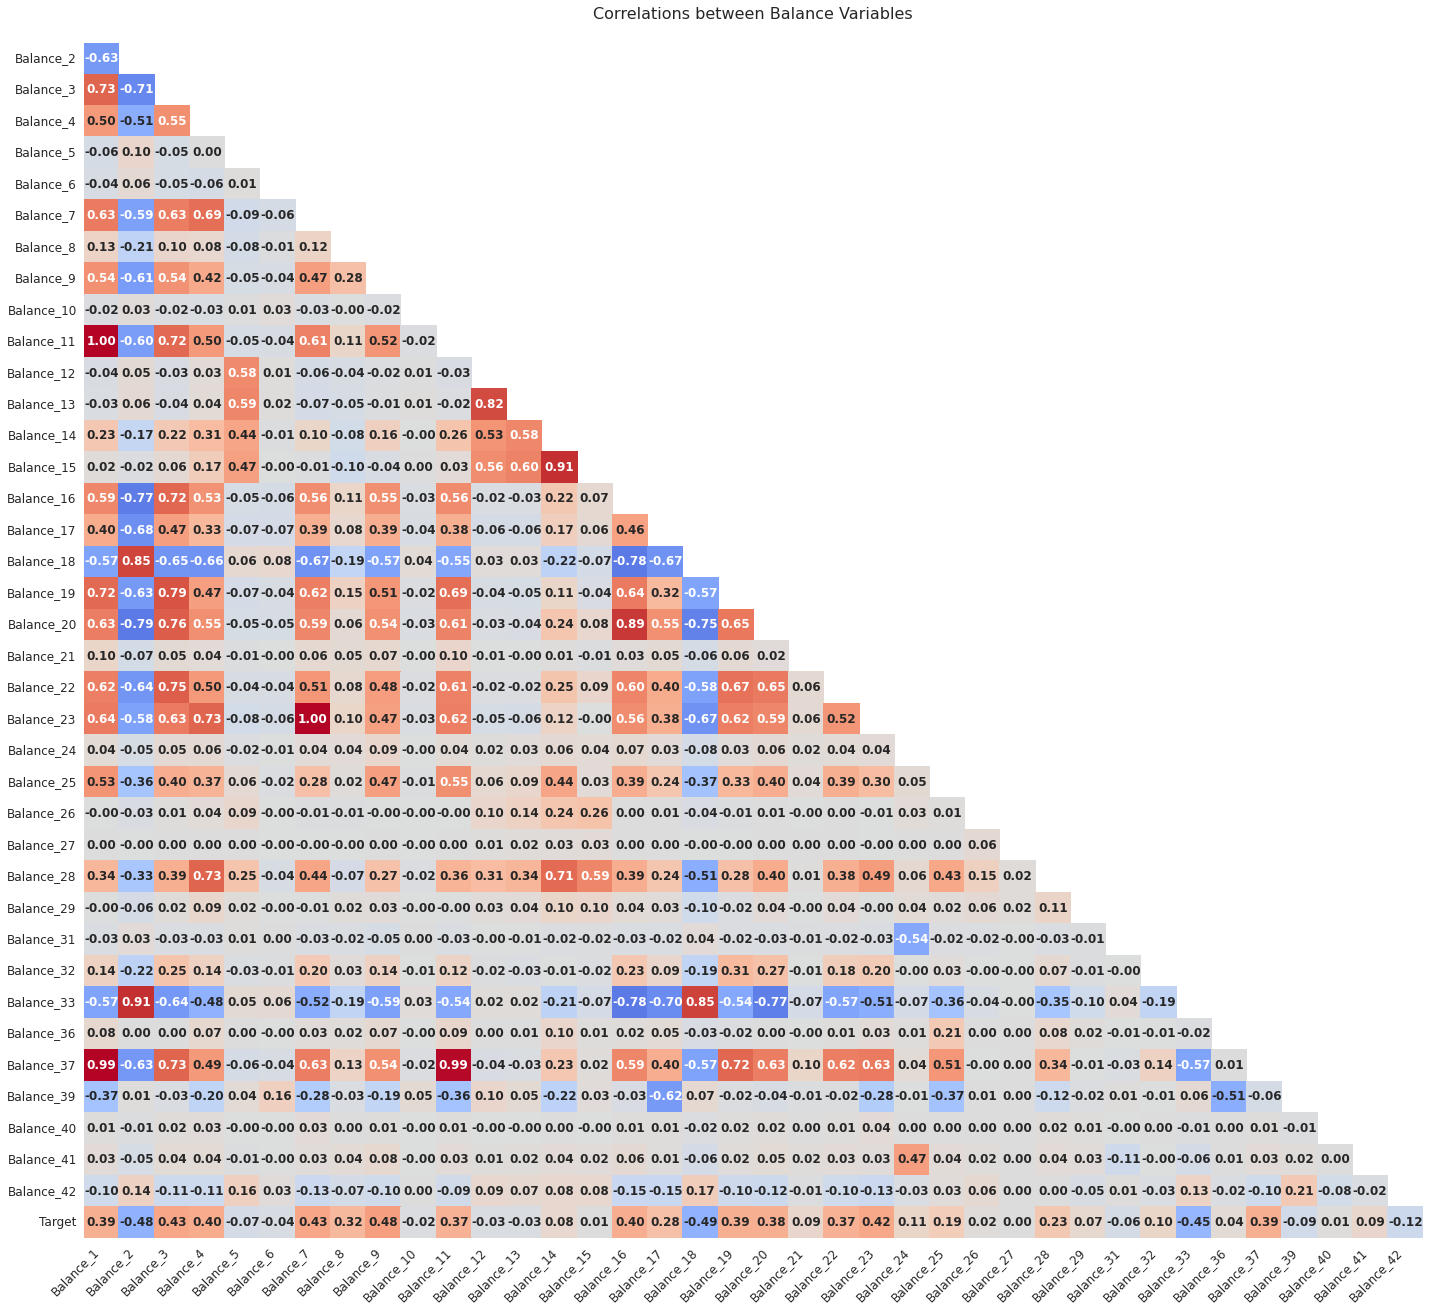

In [16]:
cols=[col for col in train.columns if (col.startswith(('B','T'))) & (col not in cat_features)]
plot_df=train[cols]
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(24,22))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Balance Variables\n', fontsize=16)
fig.show()

In [ ]:
corr=train.corr()
corr=corr['Target'].sort_values(ascending=False)[1:-1]
pal=sns.color_palette("Reds_r",135).as_hex()
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig = go.Figure()
fig.add_trace(go.Bar(x=corr[corr>=0], y=corr[corr>=0].index, 
                     marker_color=rgb, orientation='h', 
                     marker_line=dict(color=pal,width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))
pal=sns.color_palette("Blues",100).as_hex()
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig.add_trace(go.Bar(x=corr[corr<0], y=corr[corr<0].index, 
                     marker_color=rgb[25:], orientation='h', 
                     marker_line=dict(color=pal[25:],width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))
fig.update_layout(template=temp,title="Feature Correlations with Target",
                  xaxis_title="Correlation", margin=dict(l=150),
                  height=3000, width=700, hovermode='closest')
fig.show()

In [ ]:
configure_plotly_browser_state()
plot_df=train.reset_index().groupby('Spend_2')['Risk_ID'].nunique().reset_index()
fig=go.Figure()
fig.add_trace(go.Scatter(x=plot_df['Spend_2'], 
                         y=plot_df['Risk_ID'], mode='lines',
                         line=dict(color=pal[0], width=3), 
                         hovertemplate = ''))
fig.update_layout(template=temp, title="Frequency of Customer Statements", 
                  hovermode="x unified", width=800,height=500,
                  xaxis_title='Statement Date', yaxis_title='Number of Statements Issued')
fig.show()
del train['Spend_2']

TypeError: ignored

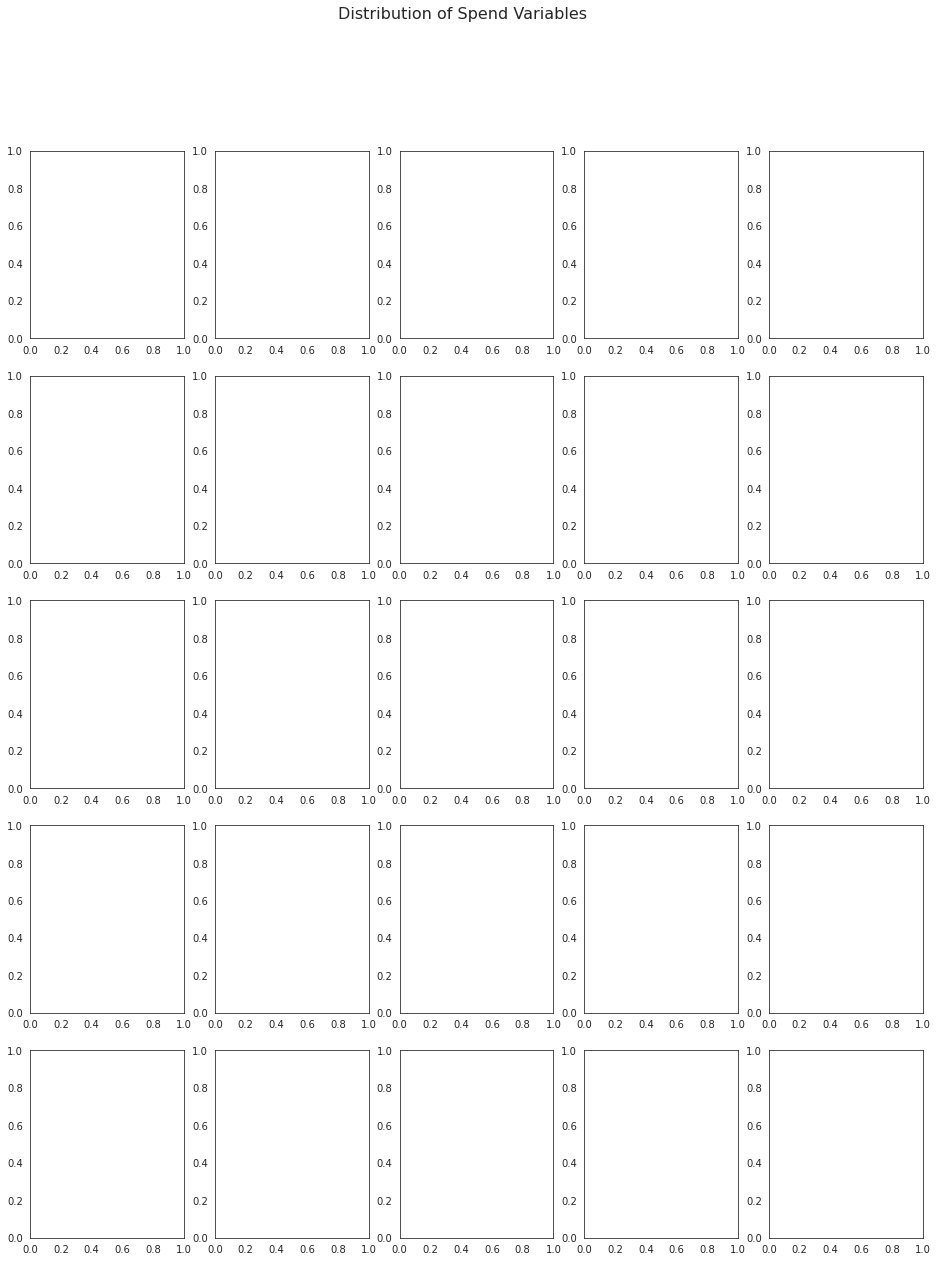

In [14]:
cols=[col for col in train.columns if (col.startswith(('P','T'))) & (col not in cat_features)]
plot_df=train[cols]
fig, ax = plt.subplots(5,5, figsize=(16,20))
fig.suptitle('Distribution of Spend Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*5
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(1,5):
    ax[4,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.985))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])